In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn import decomposition
from scipy.spatial import distance
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load data from CSV files
redundant = ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s', 'Matches']
general = pd.read_csv('general.csv', header=0).drop(['Rk', 'Matches'], axis=1)
shooting = pd.read_csv('shooting.csv', header=0).drop(redundant, axis=1)
passing = pd.read_csv('passing.csv', header=0).drop(redundant, axis=1)
passing_types = pd.read_csv('passing_types.csv', header=0).drop(redundant, axis=1)
gca = pd.read_csv('gca.csv', header=0).drop(redundant, axis=1)
defense = pd.read_csv('defense.csv', header=0).drop(redundant, axis=1)
possession = pd.read_csv('possession.csv', header=0).drop(redundant, axis=1)
misc = pd.read_csv('misc.csv', header=0).drop(redundant, axis=1)

# Helper function to rename column names
def renameColumns(table_no, df):
    num = str(table_no) + "_"
    return df.rename(columns=lambda x: num + x)

# Rename columns for each DataFrame
shooting = renameColumns(2, shooting)
passing = renameColumns(3, passing)
passing_types = renameColumns(4, passing_types)
gca = renameColumns(5, gca)
defense = renameColumns(6, defense)
possession = renameColumns(7, possession)
misc = renameColumns(8, misc)

# Concatenate all DataFrames into a single DataFrame
grand = pd.concat([general, shooting, passing, passing_types, gca, defense, possession, misc], axis=1)
df = grand[grand['90s'] >= 3]
df = df[df['Pos'] != 'GK'].reset_index()
df['Comp'] = df['Comp'].str.split(' ', expand=True, n=1)[1]

# Save the processed data using pickle
with open('outfield.pkl', 'wb') as file:
    pickle.dump(df, file)

# Create a dictionary mapping players to their IDs
players = [df['Player'][idx] + '({})'.format(df['Squad'][idx]) for idx in range(len(df))]
player_ID = dict(zip(players, np.arange(len(players))))

# Save the player-ID dictionary using pickle
with open('player_ID.pickle', 'wb') as file:
    pickle.dump(player_ID, file)

print(df)



      index             Player  Nation    Pos          Squad            Comp  \
0         0   Brenden Aaronson  us USA  MF,FW   Leeds United  Premier League   
1         4   Yunis Abdelhamid  ma MAR     DF          Reims         Ligue 1   
2         5      Himad Abdelli  fr FRA  MF,FW         Angers         Ligue 1   
3         6  Salis Abdul Samed  gh GHA     MF           Lens         Ligue 1   
4         7    Laurent Abergel  fr FRA     MF        Lorient         Ligue 1   
...     ...                ...     ...    ...            ...             ...   
2054   2883   Martín Zubimendi  es ESP     MF  Real Sociedad         La Liga   
2055   2885   Szymon Żurkowski  pl POL     MF         Spezia         Serie A   
2056   2886    Martin Ødegaard  no NOR     MF        Arsenal  Premier League   
2057   2887        Milan Đurić  ba BIH     FW  Hellas Verona         Serie A   
2058   2888      Filip Đuričić  rs SRB  MF,FW      Sampdoria         Serie A   

      Age  Born  MP  Starts  ...  8_Crs

Text(0.5, 1.0, 'Position distribution among leagues')

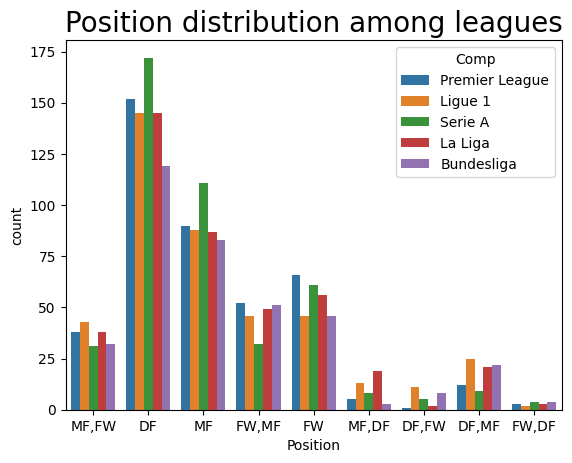

In [11]:
ax= sns.countplot(x="Pos", hue='Comp', data=df)
plt.xlabel('Position')
plt.title('Position distribution among leagues', size=20)

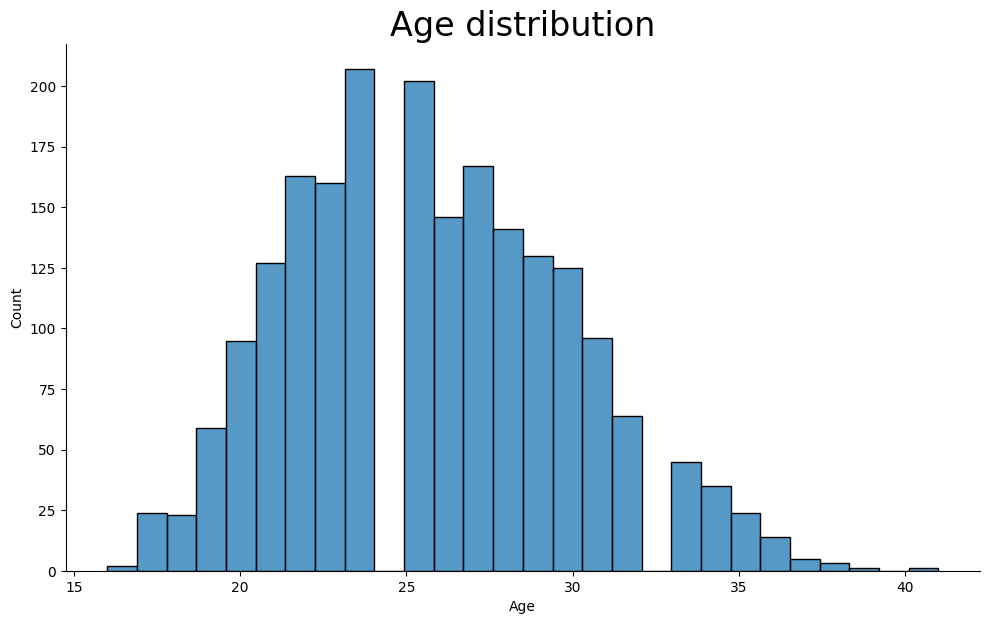

In [12]:
g = sns.FacetGrid(df, height=6, aspect=10/6)
g.map(sns.histplot, "Age", bins=28)
plt.title("Age distribution", size=24)
plt.show()

Text(0.5, 1.0, 't-SNE - Outfield players')

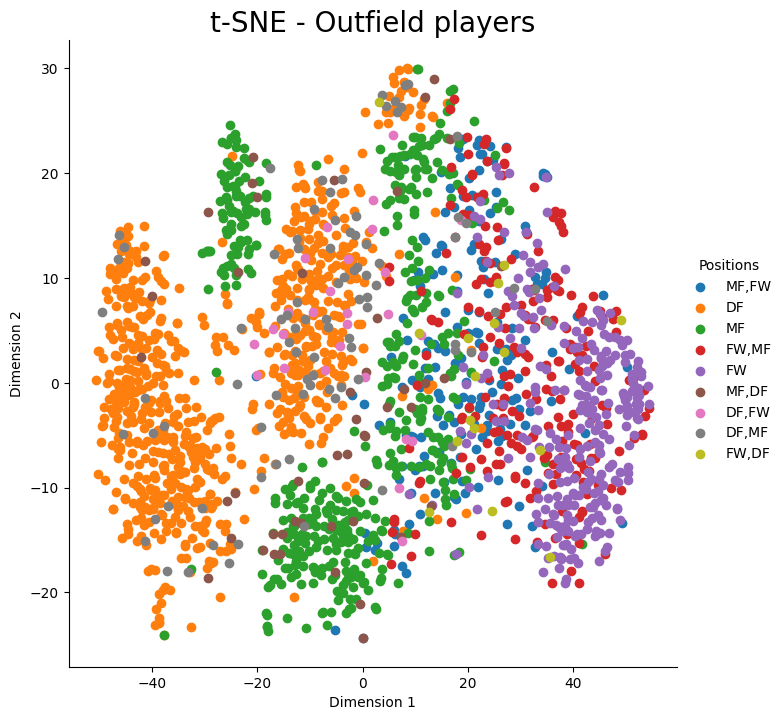

In [13]:
# selecting only numerical metrics
stats = df.iloc[:, 12:-1]
# position types
labels = df['Pos']

# standardizing the data
data = StandardScaler().fit_transform(stats)

# configuring tSNE params
model = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_data = model.fit_transform(data)

# creating a new df to plot the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Positions"))

# ploting the result of tSNE
ax = sns.FacetGrid(tsne_df, hue="Positions", height=7)\
        .map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title('t-SNE - Outfield players', size=20)

Text(0.5, 1.0, 'PCA - Outfield players')

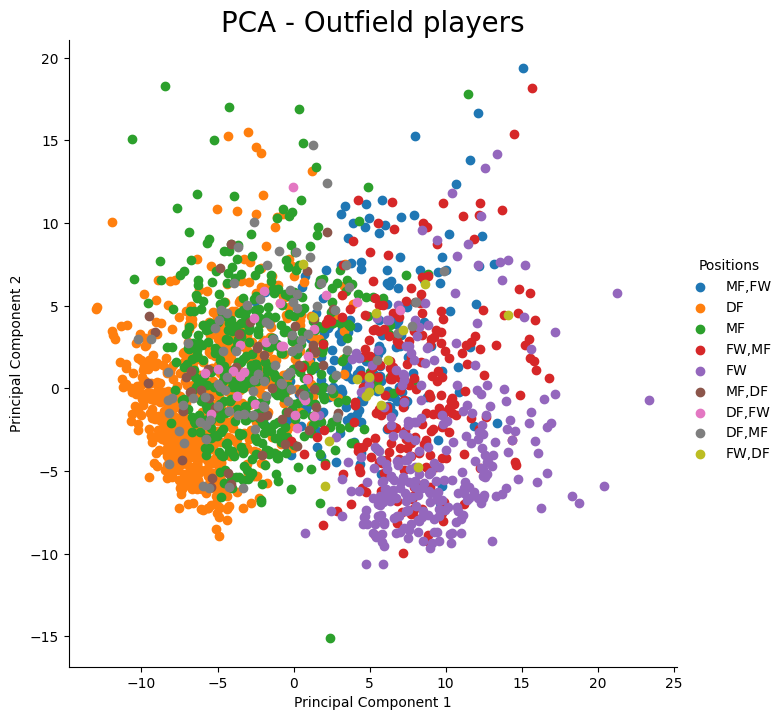

In [14]:
# selecting only numerical metrics
stats = df.iloc[:, 12:-1]
# position types
labels = df['Pos']

# standardizing the data
data = StandardScaler().fit_transform(stats)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=0)
pca_data = pca.fit_transform(data)

# creating a new DataFrame for the PCA result data
pca_df = pd.DataFrame(
    data=np.hstack((pca_data, np.array(labels)[:, np.newaxis])),  # convert labels to numpy array
    columns=["Principal Component 1", "Principal Component 2", "Positions"]
)

# plot the result of PCA
ax = sns.FacetGrid(pca_df, hue="Positions", height=7)\
        .map(plt.scatter, 'Principal Component 1', 'Principal Component 2').add_legend()
plt.title('PCA - Outfield players', size=20)


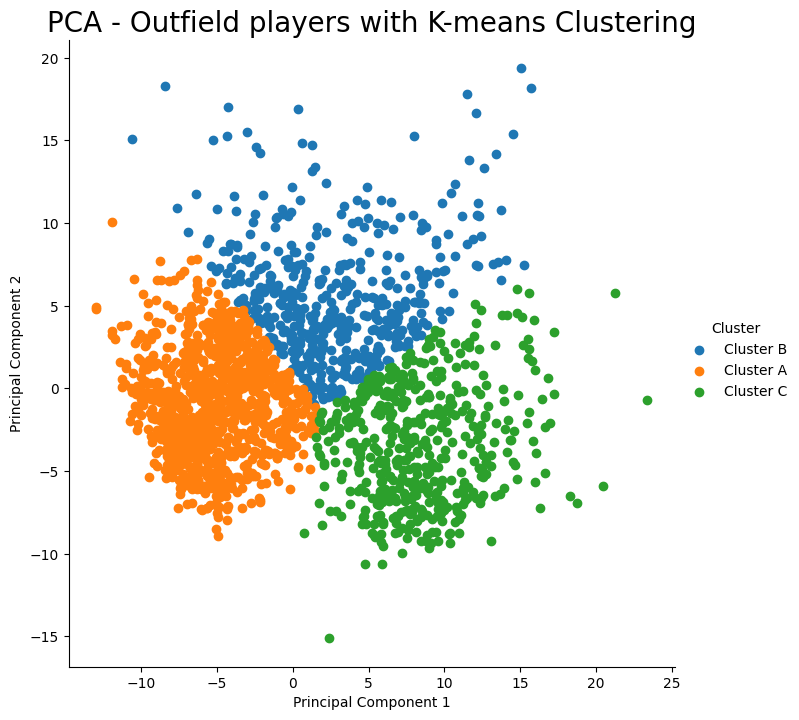

In [15]:
# selecting only numerical metrics
stats = df.iloc[:, 12:-1]
# position types
labels = df['Pos']

# standardizing the data
data = StandardScaler().fit_transform(stats)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=0)
pca_data = pca.fit_transform(data)

# creating a new DataFrame for the PCA result data
pca_df = pd.DataFrame(
    data=np.hstack((pca_data, np.array(labels)[:, np.newaxis])),  # convert labels to numpy array
    columns=["Principal Component 1", "Principal Component 2", "Positions"]
)

# Apply K-means clustering to the PCA data
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)  # explicitly set n_init
kmeans.fit(pca_data)
cluster_labels = kmeans.labels_

# Define custom cluster labels
cluster_labels_map = {0: "Cluster A", 1: "Cluster B", 2: "Cluster C"}
cluster_labels_custom = [cluster_labels_map[label] for label in cluster_labels]

# Add cluster labels to the DataFrame
pca_df['Cluster'] = cluster_labels_custom

# plot the result of PCA with cluster coloring
ax = sns.FacetGrid(pca_df, hue="Cluster", height=7)\
        .map(plt.scatter, 'Principal Component 1', 'Principal Component 2').add_legend()
plt.title('PCA - Outfield players with K-means Clustering', size=20)
plt.show()


In [16]:
stats = pca_data[:, :150]

def getStats(name):
    idx = player_ID[name]
    return stats[idx, :]

def similarity(player1, player2):
    return 1 - distance.cosine(getStats(player1), getStats(player2))

def normalize(array):
    return np.array([round(num, 2) for num in (array - min(array)) * 100 / (max(array) - min(array))])

engine = {}
for query in tqdm(players):
    metric = []
    for player in players:
        value = similarity(query, player)
        metric.append(value)
    metric = normalize(metric)
    engine[query] = metric


100%|█████████████████████████████████████████████████████████████████████████████████████| 2059/2059 [02:46<00:00, 12.36it/s]


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pickle

with open('outfield_clustered.pkl', 'rb') as file:
    df = pickle.load(file)

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 11:-2], df['Cluster'], test_size=0.2, random_state=42)

# Define the logistic regression model
model = LogisticRegression(solver='liblinear', max_iter=5000)

# Define the grid of hyperparameters to search
param_grid = {'C': [0.1, 1, 10]}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the best hyperparameters found
print("Best Hyperparameters:", best_params)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       109
           1       0.96      0.98      0.97       214
           2       0.96      0.98      0.97        89

    accuracy                           0.96       412
   macro avg       0.96      0.95      0.95       412
weighted avg       0.96      0.96      0.96       412

Best Hyperparameters: {'C': 10}


In [10]:
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-Validation Accuracy: %0.2f" % (scores.mean()))

Cross-Validation Accuracy: 0.95
